In [18]:
import sys
sys.path.append('..')
from aux.models import MMKJSQPS
import jsq_ps.models as jsq
import tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ciw

In [19]:
def plot_lamb_approx(k, ymin=0,ymax=10, xmin=0,xmax=1):
    rhos = np.arange(.01, .99, 0.01)
    lamb_i = {i: [] for i in range(4)}
    
    
    for i in lamb_i.keys():
        lamb_i[i] = [MMKJSQPS(mu=1, lambda_=rho*k, K=k).lamb(i) for rho in rhos]
        plt.plot(rhos, lamb_i[i], label=f'λ({i})')
    plt.legend()
    plt.xlabel(r'$\rho$')
    plt.ylabel(r'$\lambda(n)$')
    plt.title(f'K={k}')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.show()

# Plot $\lambda(n)$ against $\rho$

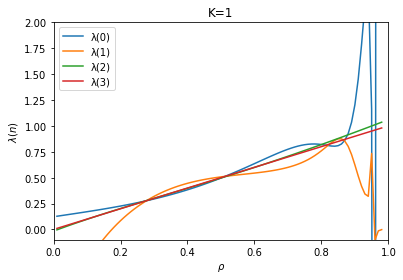

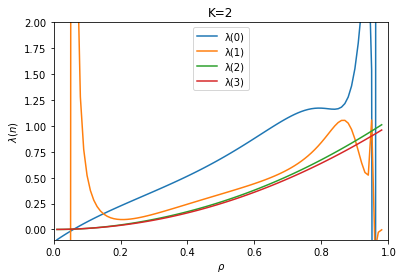

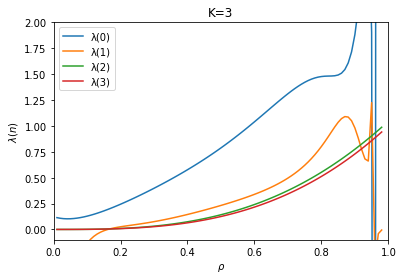

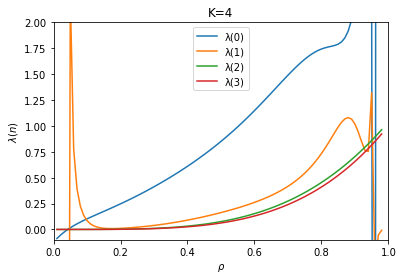

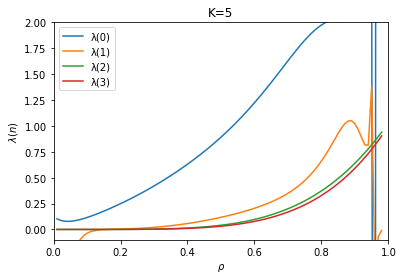

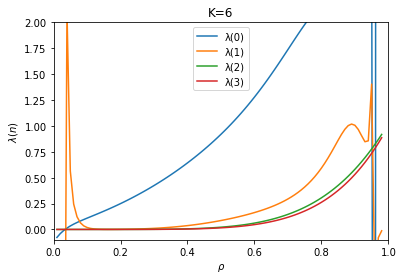

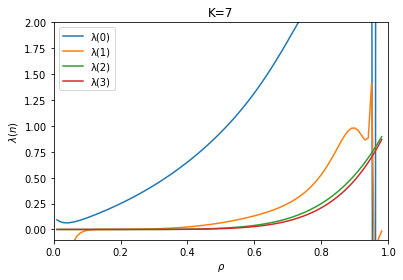

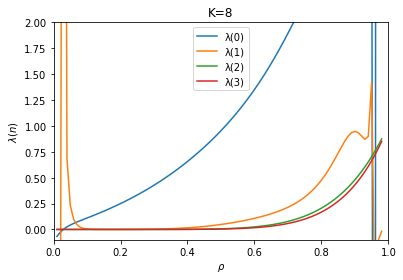

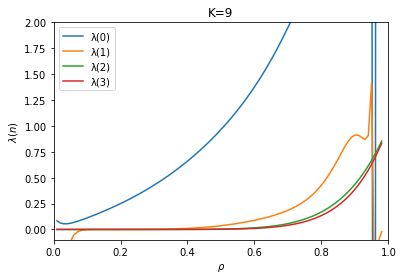

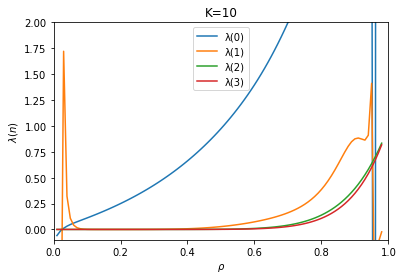

In [20]:
for k in range(1,11):
    plot_lamb_approx(k=k, ymin=-.1,ymax=2 )

# Plot $\lambda(n)$ against $\rho\in[.8,1]$
$\lambda(1)$ drops down to -12.5 at $\rho=.96$

$\lambda(1)$ pops up to 60 at $\rho=.97$

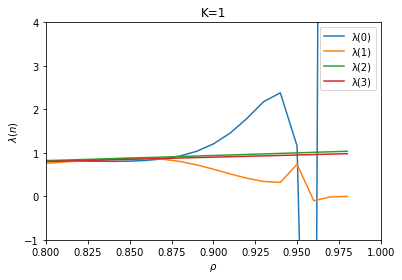

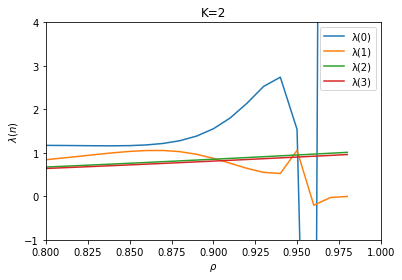

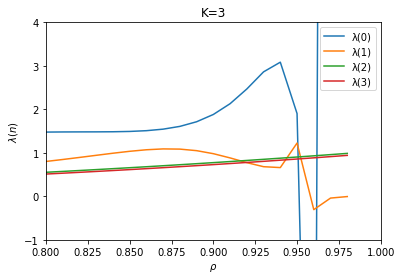

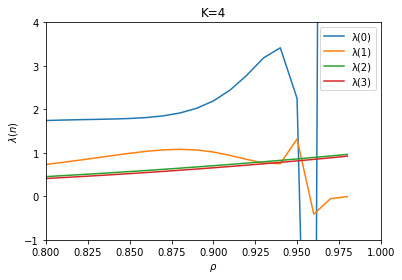

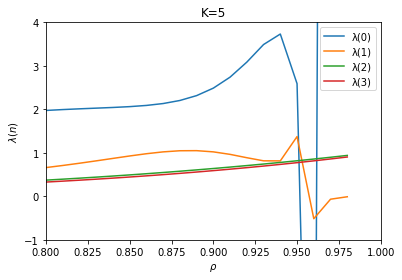

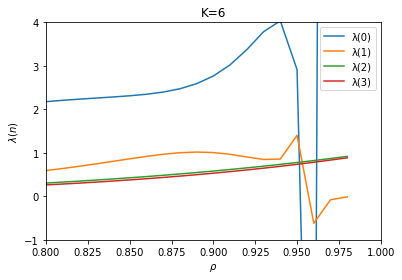

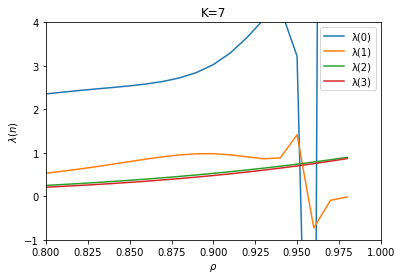

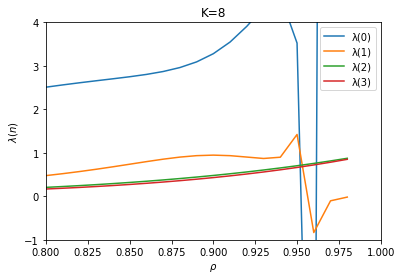

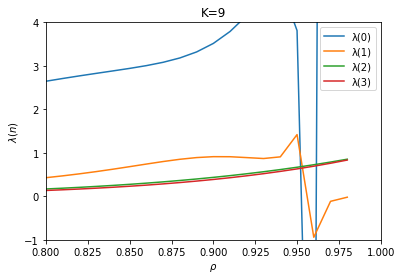

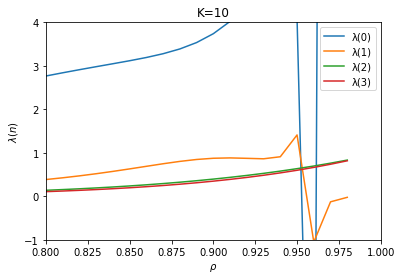

In [21]:
for k in range(1,11):
    plot_lamb_approx(k=k, ymin=-1,ymax=4, xmin=.8 )

# Compare Method 2 $\lambda(n)$ to Method 1's $\Lambda \pi(n)$ to that of Simulation

In [22]:
def get_simulation_lambdas(lambda_, mu, R, max_n):
    Sim = jsq.Simulation(lambda_=10, mu=10/(R*rho), R=R, max_time=20000, warmup=500, tracker=ciw.trackers.NodePopulationSubset(range(1,2)), ps_bar=False)
    Sim.run(0)
    recs = pd.DataFrame(Sim.recs)
    arrival_dates = list(recs.sort_values('arrival_date')['arrival_date'])
    arrival_nodes = list(recs.sort_values('arrival_date')['node'] - 2)
    arrival_state_n1 = []
    i = 0
    for nd, date in zip(arrival_nodes, arrival_dates):
        while Sim.tracker.history[i][0] < date:
            i += 1
        state = list(Sim.tracker.history[i][1])
        if nd == 0:
            arrival_state_n1.append(state[0] - 1)
        else:
            arrival_state_n1.append(state[0])
#     print(len(arrival_dates), len(arrival_nodes), len(arrival_state_n1))
    state_data = pd.DataFrame({
        'date': arrival_dates,
        'node': arrival_nodes,
        'state 1': arrival_state_n1
    })
    props = [state_data[state_data['state 1'] == i]['node'].value_counts().get(0, 0) / state_data[state_data['state 1'] == i]['node'].count() for i in range(max_n)]
    return [lambda_ * p for p in props]

In [23]:
# Decide whiche mc_limit to use (we want number of matrix transitions to be less than 10 million)
for R in range(1, 10):
    limit = (10000000 ** (1 / (2 * R))) - 1
    print(limit)

3161.2776601683795
55.23413251903491
13.677992676220693
6.498942093324558
4.011872336272723
2.8311868495572874
2.162277660168379
1.7384196342643614
1.4484367468222268


In [24]:
mc_limits = {1: 100, 2: 30, 3: 13, 4: 6, 5: 4}
for R in range(1, 5):
    t = (mc_limits[R] + 1) ** (2 * R)
    print(R, t)

1 10201
2 923521
3 7529536
4 5764801


In [25]:
def plot_m1_v_m2(ax, R, rho):
    max_n = 8
    M1 = jsq.Method1(lambda_=10, mu=10/(R*rho), R=R, mc_limit=mc_limits[R], infty=140, zero=0)
    M2 = jsq.Method2(lambda_=10, mu=10/(R*rho), R=R, infty=140)
    m1_lamb_dict = {i: l for i, l in enumerate(M1.lambda_ns)}
    m1_lambs = [m1_lamb_dict.get(i, 0) for i in range(max_n)]
    m2_lambs = [M2.M.lamb_n[i] for i in range(max_n)]
    sim_lambda = get_simulation_lambdas(lambda_=10, mu=10/(R*rho), R=R, max_n=max_n)
    ax.plot(range(max_n), m1_lambs, label='Method 1')
    ax.plot(range(max_n), m2_lambs, label='Method 2')
    ax.plot(range(max_n), sim_lambda, label='Simulation')
    ax.set_title(fr"R = {R}, $\rho$ = {rho}", fontsize=12)
    ax.set_xlabel(r'$n$')
    ax.set_ylabel(r'$\lambda_n$')
#     ax.set_ylim(bottom=0)
    ax.set_xticks(range(max_n))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.legend(fontsize=8)

Doing R = 1

Doing R = 2

Doing R = 3

Doing R = 4



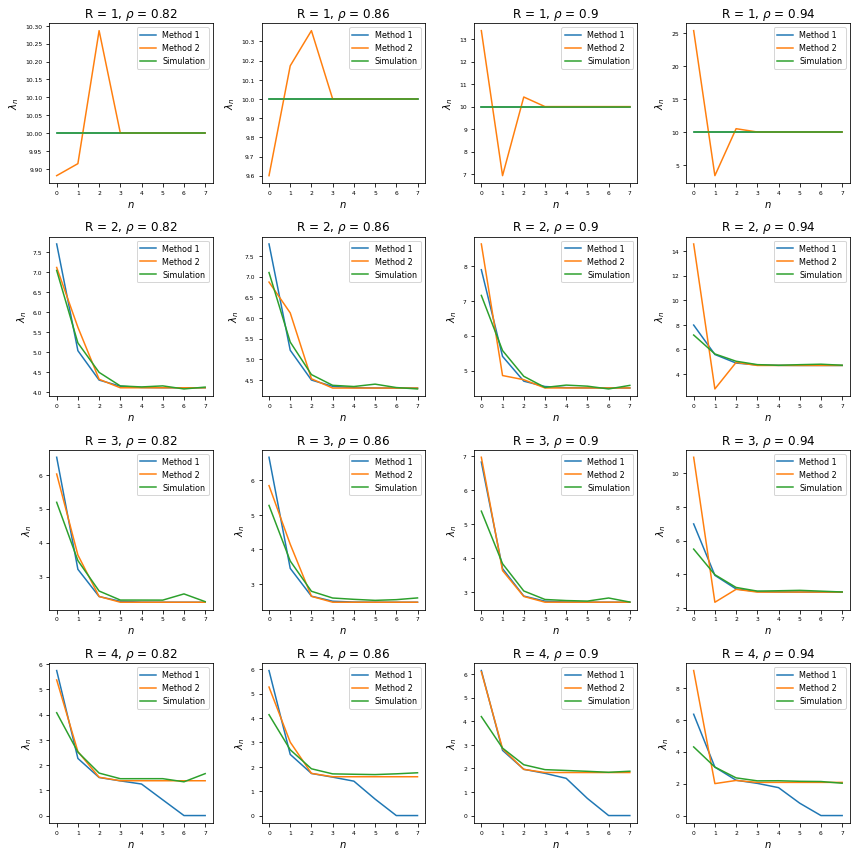

In [26]:
fig, axarr = plt.subplots(4, 4, figsize=(12, 12))
for i, R in enumerate([1, 2, 3, 4]):
    print(f"Doing R = {R}")
    for j, rho in enumerate([0.82, 0.86, 0.9, 0.94]):
        plot_m1_v_m2(axarr[i, j], R, rho)
    print('\r')
plt.tight_layout()
plt.show()